<a href="https://colab.research.google.com/github/outliers8224/Deeplearning/blob/main/Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##ResNet
Proposed in 2015 by Kaiming He et al., introduced the concept of residual learning to address the vanishing gradient problem in deep neural networks. By utilizing skip connections, ResNet enables the learning of residual mappings, improving optimization and accuracy in deeper networks. This innovation revolutionized deep learning architecture, paving the way for unprecedented performance in image recognition tasks.


In [ ]:
!pip install Augmentor


In [ ]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("GPU available")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("No GPU available")

No GPU available


In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

In [ ]:
import os
# import cv2
import Augmentor
import shutil
from PIL import Image

In [ ]:
!git clone https://github.com/makhan010385/Soybean-.git

fatal: destination path 'Soybean-' already exists and is not an empty directory.


In [ ]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
  '/content/Soybean-',
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 345 files belonging to 2 classes.


In [ ]:
class_names = train_data.class_names
class_names

['Soybean Leaf Dataset for Disease Classification',
 'Soybean Seeds Stage Prediction']

In [ ]:
print("Tensor Object")
train_data.take(1)

Tensor Object


<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

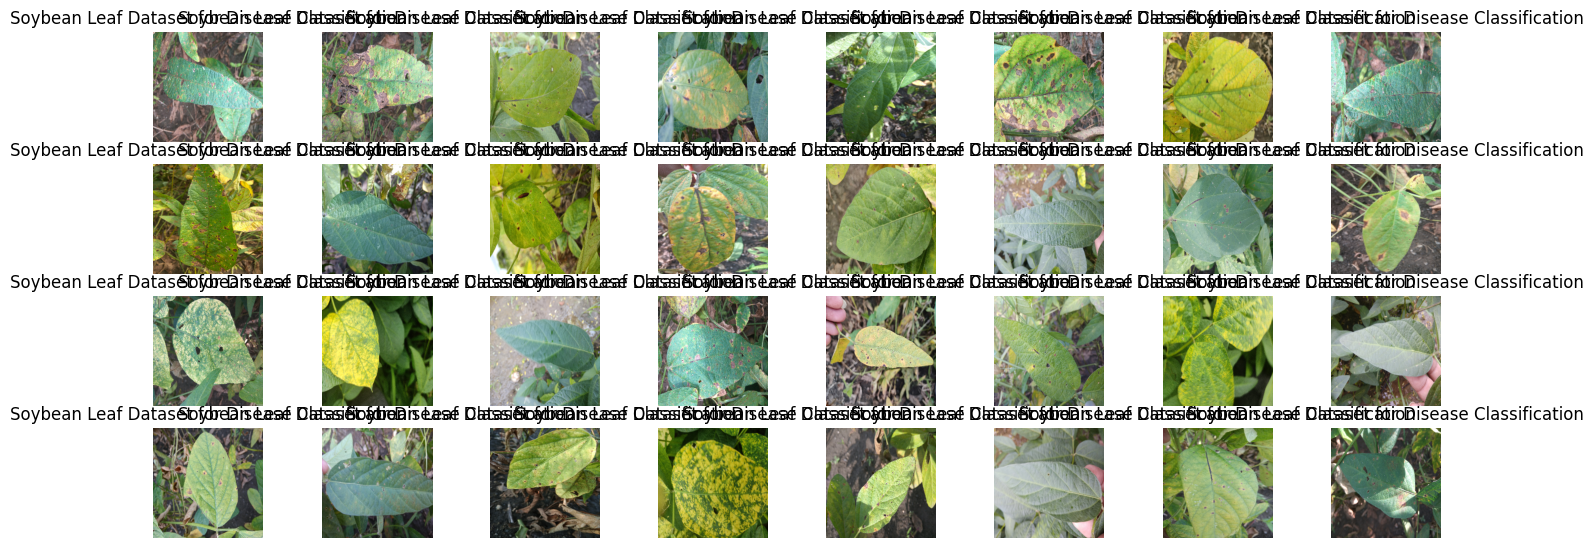

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(17,10))

for image_batch, label_batch in train_data.take(1):

    for i in range(image_batch.shape[0]):

        ax = plt.subplot(6,8,i+1)   # 4 rows, 8 columns
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [ ]:
def get_dataset_partition_tf( ds, test_split=0.15, val_split=0.15, shuffle=True, shuffle_size=100):

  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle( shuffle_size, seed=12 )

  val_size = int( val_split * ds_size )

  val_ds = ds.skip( val_size )
  test_ds = ds.skip( val_size )

  return test_ds, val_ds

In [ ]:
test_ds, val_ds = get_dataset_partition_tf( test_data, test_split = 0.5, val_split = 0.5 )

print( "Training Batches :", len(train_data) )
print( "Testing Batches :", len(test_ds) )
print( "validation Batches :", len(val_ds) )

In [ ]:
train_ds = train_data.cache().shuffle(100).prefetch( buffer_size = tf.data.AUTOTUNE )
test_ds = test_ds.cache().shuffle(100).prefetch( buffer_size = tf.data.AUTOTUNE )
val_ds = val_ds.cache().shuffle(100).prefetch( buffer_size = tf.data.AUTOTUNE )

In [ ]:
from tensorflow.keras import models, layers, applications

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing( IMAGE_SIZE, IMAGE_SIZE ),
    layers.experimental.preprocessing.Rescaling( 1.0/255 )
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(0.2),
  layers.experimental.preprocessing.RandomContrast(0.2),
])

In [ ]:
from tensorflow.keras import applications, models, layers, optimizers
from tensorflow.keras.regularizers import l2

# Define input shape and number of classes
input_shape = (IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 6

# Load pre-trained ResNet50 model (without top classification layers)
base_model = applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the pre-trained layers
base_model.trainable = False

# Add regularization to the dense layers
regularization = 0.001  # Adjust regularization strength as needed

# Create a new model by adding custom classification layers on top of the pre-trained model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu', kernel_regularizer=l2(regularization)),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax', kernel_regularizer=l2(regularization))
])

# Compile the model with a lower learning rate
optimizer = optimizers.Adam(lr=0.0001)  # Lower learning rate
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=3,
    verbose=1,
)
model_checkpoint = ModelCheckpoint(
    filepath="./resnet50_mode4.h5",            # check it
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1,
)
model_callbacks = [early_stopping, model_checkpoint]

In [ ]:
history = model.fit(
    train_ds,
    epochs = 50,
    batch_size= BATCH_SIZE,
    verbose =1,
    validation_data=val_ds,
    callbacks=model_callbacks,
)

In [ ]:
score = model.evaluate(test_ds)

In [ ]:
def pesticidee(img_name):
    if img_name=='Frogeye Leaf Spot':
        return('sol ')
    elif img_name=='Rust':
        return('furadan applicatio')
    elif img_name=='Bacterial postule':
        return('Spray 2.5kg of carbaryl')
    elif img_name=='FLS':
        return('sol')
    elif img_name=='Sudden Death Syndrome':
        return('Buprofezin 25% SC')
    elif img_name=='Yellow Mosaic':
        return('Permethrin, bifenthrin, lambda cyhalothrin and carbaryl')

In [ ]:
import numpy as np

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())   #convert image into array
    img_array = tf.expand_dims(img_array, 0)                  # creat a batch

    predictions = model.predict(img_array)
    print(predictions)
    predicted_class = class_names[np.argmax(predictions[0])]

    confidence = round(100 * (np.max(predictions[0])), 2)
    Pesticidee = pesticidee(predicted_class)
    return predicted_class, confidence , Pesticidee

In [ ]:
plt.figure(figsize=(20,23))

for images,labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence , Pesticidee = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}%,\n Solution: {Pesticidee}")

        plt.axis("off")

In [ ]:
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from matplotlib import pyplot as plt

image_path = r'D:\test\Bac1.jpg'

#load
image = load_img(image_path , target_size=(IMAGE_SIZE , IMAGE_SIZE))
img_array = img_to_array(image)   #convert image into array
img_array = tf.expand_dims(img_array, 0)                  # creat a batch

predictions = model.predict(img_array)
print(predictions)
predicted_class = class_names[np.argmax(predictions)]

confidence = round(100 * (np.max(predictions)), 2)
Pesticidee = pesticidee(predicted_class)

plt.imshow(image)
plt.title(f"Predicted class : {predicted_class}\n Confidence: {confidence}% \n Pesticide: {Pesticidee}" )
plt.axis('off')
